# Telco Customer Churn Prediction - Model Development

This is the third and final notebook in a series of notebooks developing a machine learning model to predict customer churn for a telecommunications company. In the previous notebooks, I cleaned and merged the excel files provided in [IBM's sample datasets](https://accelerator.ca.analytics.ibm.com/bi/?perspective=authoring&pathRef=.public_folders%2FIBM%2BAccelerator%2BCatalog%2FContent%2FDAT00148&id=i9710CF25EF75468D95FFFC7D57D45204&objRef=i9710CF25EF75468D95FFFC7D57D45204&action=run&format=HTML&cmPropStr=%7B%22id%22%3A%22i9710CF25EF75468D95FFFC7D57D45204%22%2C%22type%22%3A%22reportView%22%2C%22defaultName%22%3A%22DAT00148%22%2C%22permissions%22%3A%5B%22execute%22%2C%22read%22%2C%22traverse%22%5D%7D) into a single CSV file containing a consolidated dataset, examined and transformed the dataset features thoroughly and prepared the dataset for the modeling stage.

In this notebook, I will:

- Create preprocessing and modeling pipelines

- Compare baseline models with cross-validation

- Address class imbalance using alternative techniques

- Analyze experimentation results, and combine with various business objectives to decide on best three models

- Tune hyperparameters of the best models using model-specific parameter grids

- Measure performance of final models on the test set including classification reports, confusion matrices and ROC curve visualizations

- Analyze feature importance using model-specific importance methods

- Summarize model performance with key drivers of customer churn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="Unlike other reduction functions")

## 1. Loading and inspecting data

In [3]:
telco = pd.read_csv("../data/processed/telco_cleaned.csv", index_col=0)

print(f"Shape: {telco.shape}")
telco.head()

Shape: (7043, 29)


,gender,age,married,number_of_dependents,number_of_referrals,tenure_in_months,offer,phone_service,avg_monthly_long_distance_charges,multiple_lines,internet_type,avg_monthly_gb_download,online_security,online_backup,device_protection_plan,premium_tech_support,streaming_tv,unlimited_data,contract,paperless_billing,payment_method,monthly_charge,total_refunds,total_extra_data_charges,churn_value,cltv,streaming,log_total_long_distance_charges,log_total_revenue
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,Female,37,1,0,2,9,no_offer,1,42.39,0,Cable,16,0,1,0,1,1,1,One Year,1,Credit Card,65.6,0.00,0,0,2205,0,5.946755,6.883268
0003-MKNFE,Male,46,0,0,0,9,no_offer,1,10.69,1,Cable,10,0,0,0,0,0,0,Month-to-Month,0,Credit Card,59.9,38.33,10,0,5414,1,4.576874,6.415555
0004-TLHLJ,Male,50,0,0,0,4,Offer E,1,33.65,0,Fiber Optic,30,0,0,1,0,0,1,Month-to-Month,1,Bank Withdrawal,73.9,0.00,0,1,4479,0,4.909709,6.031766
0011-IGKFF,Male,78,1,0,1,13,Offer D,1,27.82,0,Fiber Optic,4,0,1,1,0,1,1,Month-to-Month,1,Bank Withdrawal,98.0,0.00,0,1,3714,0,5.893466,7.378078
0013-EXCHZ,Female,75,1,0,3,3,no_offer,1,7.38,0,Fiber Optic,11,0,0,0,1,1,1,Month-to-Month,1,Credit Card,83.9,0.00,0,1,3464,0,3.141563,5.671741


In [4]:
def cardinality(df, max_display=3):
    res = pd.DataFrame({
        'nunique': df.nunique(),
        'dtype': df.dtypes
    }).sort_values(by='nunique')

    res['unique_values'] = [
        df[col].unique().tolist() if res.loc[col, 'nunique'] <= max_display
        else f"[{', '.join(map(str, df[col].unique()[:max_display]))} ...(cont'd)]"
        for col in res.index
    ]

    res['missing_value_count'] = [
        df[col].isna().sum() for col in df.columns
    ]

    return res

cardinality(telco)

,nunique,dtype,unique_values,missing_value_count
gender,2,object,"[Female, Male]",0
streaming,2,int64,"[0, 1]",0
churn_value,2,int64,"[0, 1]",0
paperless_billing,2,int64,"[1, 0]",0
unlimited_data,2,int64,"[1, 0]",0
streaming_tv,2,int64,"[1, 0]",0
premium_tech_support,2,int64,"[1, 0]",0
online_backup,2,int64,"[1, 0]",0
online_security,2,int64,"[0, 1]",0
device_protection_plan,2,int64,"[0, 1]",0


## 2. Creating a preprocessing pipeline

In [5]:
# Separate target variable
X = telco.drop(['churn_value'], axis=1)
y = telco['churn_value']

# Separate dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

print("\nChurn distribution before splitting:")
print(y.value_counts(normalize=True + 100) * 100)

print("\nTraining set churn distribution:")
print(pd.Series(y_train).value_counts(normalize=True) * 100)

print("\nTest set churn distribution:")
print(pd.Series(y_test).value_counts(normalize=True) * 100)

Training set size: 5634 samples
Test set size: 1409 samples

Churn distribution before splitting:
churn_value
0    73.463013
1    26.536987
Name: proportion, dtype: float64

Training set churn distribution:
churn_value
0    73.464679
1    26.535321
Name: proportion, dtype: float64

Test set churn distribution:
churn_value
0    73.456352
1    26.543648
Name: proportion, dtype: float64


In [6]:
# Identify numerical and categorical features for preprocessing
cat_features = X.select_dtypes(include=['object']).columns.to_list()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.to_list()

print(f"Categorical features ({len(cat_features)}):")
print(cat_features)
print(f"\nNumerical features ({len(num_features)}):")
print(num_features)

Categorical features (5):
['gender', 'offer', 'internet_type', 'contract', 'payment_method']

Numerical features (23):
['age', 'married', 'number_of_dependents', 'number_of_referrals', 'tenure_in_months', 'phone_service', 'avg_monthly_long_distance_charges', 'multiple_lines', 'avg_monthly_gb_download', 'online_security', 'online_backup', 'device_protection_plan', 'premium_tech_support', 'streaming_tv', 'unlimited_data', 'paperless_billing', 'monthly_charge', 'total_refunds', 'total_extra_data_charges', 'cltv', 'streaming', 'log_total_long_distance_charges', 'log_total_revenue']


In [7]:
# Standard scaling for numerical features
num_tr = Pipeline([
    ('scaler', StandardScaler())
])

# One-hot encoding for categorical features
cat_tr = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine both in a preprocessor
preprocessor = ColumnTransformer([
    ('num', num_tr, num_features),
    ('cat', cat_tr, cat_features)
])

Note that while tree-based models aren't affected by scaling, it doesn't harm them, and maintaining a consistent preprocessing pipeline is cleaner.

## 3. Model fitting

In this section, I'll perform an inital evaluation on several baseline models based on their precision, recall and F1 scores via cross-validation. I'll consider two methods to tackle class imbalance: Classs weights and SMOTE. I'll combine the results of these experiments in a dataframe for better comparison.

I'll start by setting up a stratified k-fold which maintains the same class distribution in each fold, and custom scorers which give more flexibility for cross-validation and hyperparameter search processes. Note that `zero_division=0` assigns a precision of 0 when no positive samples are predicted.

In [8]:
# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Custome scorers fto use within pipelines
f1_scorer = make_scorer(f1_score)
precision_scorer = make_scorer(precision_score, zero_division=0)
recall_scorer = make_scorer(recall_score)

## 3.1 Baseline model fit

In [9]:
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    
    'Linear SVM': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LinearSVC(random_state=42, max_iter=2000, dual=False))
    ]),
    
    'Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
    ]),
    
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1))
    ]),
    
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ]),
    
    'KNN': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier(n_jobs=-1))
    ]),
    
    'Naive Bayes': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GaussianNB())
    ])
}


# Evaluate baseline models
results = {}
for name, model in models.items():
    scores_f1 = cross_val_score(model, X, y, cv=cv, scoring=f1_scorer, n_jobs=-1)
    scores_precision = cross_val_score(model, X, y, cv=cv, scoring=precision_scorer, n_jobs=-1)
    scores_recall = cross_val_score(model, X, y, cv=cv, scoring=recall_scorer, n_jobs=-1)

    results[name] = {
        'mean_f1': scores_f1.mean(),
        'std_f1': scores_f1.std(),
        'mean_precision': scores_precision.mean(),
        'std_precision': scores_precision.std(),
        'mean_recall': scores_recall.mean(),
        'std_recall': scores_recall.std()
    }

In [10]:
# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df

,mean_f1,std_f1,mean_precision,std_precision,mean_recall,std_recall
Logistic Regression,0.691492,0.008649,0.720380,0.019909,0.665583,0.017759
Linear SVM,0.688844,0.007279,0.716662,0.019690,0.663978,0.019136
Decision Tree,0.601198,0.017524,0.591951,0.013296,0.611029,0.024890
Random Forest,0.662747,0.014138,0.732740,0.016689,0.605654,0.024071
XGBoost,0.672904,0.010808,0.702620,0.024897,0.646325,0.013944
Gradient Boosting,0.689043,0.011972,0.737807,0.004290,0.646855,0.023847
KNN,0.608093,0.016726,0.613990,0.015821,0.602472,0.020207
Naive Bayes,0.673343,0.005833,0.573257,0.008835,0.815947,0.006348


## 3.2 Models with balanced class weights

Most models have a `class_weight` parameter. For xgboost I'll calculate `scale_pos_weight` manually. I'll skip gradient boosting, KNN and naive Bayes in this section as they don't have a direct class weight parameter.

In [11]:
balanced_models = {
    'Balanced Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
    ]),
    
    'Balanced Linear SVM': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LinearSVC(random_state=42, max_iter=2000, class_weight='balanced', dual=False))
    ]),
    
    'Balanced Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
    ]),
    
    'Balanced Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
    ]),
    
    'Balanced XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(
            random_state=42, 
            eval_metric='logloss',
            scale_pos_weight=(len(y) - sum(y))/sum(y),
            n_jobs=-1
        ))
    ])
}

# Evaluate models with balanced class weights
balanced_results = {}
for name, model in balanced_models.items():
    scores_f1 = cross_val_score(model, X, y, cv=cv, scoring=f1_scorer, n_jobs=-1)
    scores_precision = cross_val_score(model, X, y, cv=cv, scoring=precision_scorer, n_jobs=-1)
    scores_recall = cross_val_score(model, X, y, cv=cv, scoring=recall_scorer, n_jobs=-1)

    balanced_results[name] = {
        'mean_f1': scores_f1.mean(),
        'std_f1': scores_f1.std(),
        'mean_precision': scores_precision.mean(),
        'std_precision': scores_precision.std(),
        'mean_recall': scores_recall.mean(),
        'std_recall': scores_recall.std()
    }

In [12]:
# Convert results to DataFrame for easier comparison
balanced_results_df = pd.DataFrame.from_dict(balanced_results, orient='index')
balanced_results_df

,mean_f1,std_f1,mean_precision,std_precision,mean_recall,std_recall
Balanced Logistic Regression,0.690043,0.007722,0.582823,0.011795,0.845903,0.006096
Balanced Linear SVM,0.683874,0.010060,0.571700,0.014618,0.851251,0.007037
Balanced Decision Tree,0.584986,0.011947,0.593080,0.014517,0.577316,0.014273
Balanced Random Forest,0.662451,0.005765,0.742899,0.013845,0.598174,0.014787
Balanced XGBoost,0.687573,0.012323,0.656796,0.014539,0.722299,0.027523


## 3.3 SMOTE resampling

In order to avoid data leakage, I'll integrate SMOTE resampler into the pipeline containing preprocessing and the model.

In [13]:
smote_models = {
    'SMOTE Logistic Regression': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    
    'SMOTE Linear SVM': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', LinearSVC(random_state=42, max_iter=2000, dual=False))
    ]),
    
    'SMOTE Decision Tree': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    
    'SMOTE Random Forest': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
    ]),
    
    'SMOTE XGBoost': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1))
    ]),
    
    'SMOTE Gradient Boosting': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ]),

    'SMOTE KNN': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', KNeighborsClassifier(n_jobs=-1))
    ]),
    
    'SMOTE Naive Bayes': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', GaussianNB())
    ])
}

# Evaluate SMOTE models
smote_results = {}
for name, model in smote_models.items():
    scores_f1 = cross_val_score(model, X, y, cv=cv, scoring=f1_scorer, n_jobs=-1)
    scores_precision = cross_val_score(model, X, y, cv=cv, scoring=precision_scorer, n_jobs=-1)
    scores_recall = cross_val_score(model, X, y, cv=cv, scoring=recall_scorer, n_jobs=-1)

    smote_results[name] = {
        'mean_f1': scores_f1.mean(),
        'std_f1': scores_f1.std(),
        'mean_precision': scores_precision.mean(),
        'std_precision': scores_precision.std(),
        'mean_recall': scores_recall.mean(),
        'std_recall': scores_recall.std()
    }

In [14]:
# Convert results to DataFrame for easier comparison
smote_results_df = pd.DataFrame.from_dict(smote_results, orient='index')
smote_results_df

,mean_f1,std_f1,mean_precision,std_precision,mean_recall,std_recall
SMOTE Logistic Regression,0.692533,0.007392,0.592217,0.012518,0.834129,0.007157
SMOTE Linear SVM,0.685901,0.008573,0.580526,0.013382,0.838409,0.007640
SMOTE Decision Tree,0.602931,0.018776,0.577151,0.018270,0.631362,0.022839
SMOTE Random Forest,0.688346,0.004252,0.692949,0.012765,0.684310,0.014946
SMOTE XGBoost,0.681660,0.004722,0.683669,0.010923,0.680035,0.013471
SMOTE Gradient Boosting,0.707020,0.005645,0.677655,0.007646,0.739420,0.016575
SMOTE KNN,0.601112,0.006557,0.478093,0.005872,0.809525,0.012788
SMOTE Naive Bayes,0.665434,0.004730,0.565148,0.011656,0.809521,0.010797


## 3.4 Combine scores from all experiments

In [15]:
# Combine all results
all_results = pd.concat([results_df, balanced_results_df, smote_results_df])

print("Best models on F1-score:")
display(all_results.sort_values(by='mean_f1', ascending=False)[:5])

print("Best models on precision:")
display(all_results.sort_values(by='mean_precision', ascending=False)[:5])

print("Best models on recall:")
display(all_results.sort_values(by='mean_recall', ascending=False)[:5])

Best models on F1-score:


,mean_f1,std_f1,mean_precision,std_precision,mean_recall,std_recall
SMOTE Gradient Boosting,0.707020,0.005645,0.677655,0.007646,0.739420,0.016575
SMOTE Logistic Regression,0.692533,0.007392,0.592217,0.012518,0.834129,0.007157
Logistic Regression,0.691492,0.008649,0.720380,0.019909,0.665583,0.017759
Balanced Logistic Regression,0.690043,0.007722,0.582823,0.011795,0.845903,0.006096
Gradient Boosting,0.689043,0.011972,0.737807,0.004290,0.646855,0.023847


Best models on precision:


,mean_f1,std_f1,mean_precision,std_precision,mean_recall,std_recall
Balanced Random Forest,0.662451,0.005765,0.742899,0.013845,0.598174,0.014787
Gradient Boosting,0.689043,0.011972,0.737807,0.004290,0.646855,0.023847
Random Forest,0.662747,0.014138,0.732740,0.016689,0.605654,0.024071
Logistic Regression,0.691492,0.008649,0.720380,0.019909,0.665583,0.017759
Linear SVM,0.688844,0.007279,0.716662,0.019690,0.663978,0.019136


Best models on recall:


,mean_f1,std_f1,mean_precision,std_precision,mean_recall,std_recall
Balanced Linear SVM,0.683874,0.010060,0.571700,0.014618,0.851251,0.007037
Balanced Logistic Regression,0.690043,0.007722,0.582823,0.011795,0.845903,0.006096
SMOTE Linear SVM,0.685901,0.008573,0.580526,0.013382,0.838409,0.007640
SMOTE Logistic Regression,0.692533,0.007392,0.592217,0.012518,0.834129,0.007157
Naive Bayes,0.673343,0.005833,0.573257,0.008835,0.815947,0.006348


## 4. Strategy moving forward

This project's ultimate goal is to build prediction models for customer churn and interpret which features are important in this process. It is possible to approach the business problem from several aspects:

- The priority may be on catching as many potential churners as possible. This means minimizing false negatives in the target, or equivalently, prioritizing recall.

- The priority may be on identifying true churners with fewer false alarms. This means minimizing false positives in the target, or equivalently, prioritizing precision.

- The priority may be on both of the two aims above, on a balanced model with best overall performance. This means prioritizing f1-score, which is particularly valuable when you need to balance false positives and false negatives.

I want the end result of this project to answer all three needs above. Therefore, I'll choose three models from the expose above, and move further with hyperparameter tuning and feature importance in all three avenues simultaneously.

In order to have consistency in this process, I'll choose to use a common preprocessor that includes scaling for all pipelines.

Moreover, I'll choose to have the same technique for handling class imbalance: Class weights. There are several resaons for this choice:

- The target imbalance is not severe, roughly %27 to %73, and introducing synthetic data might indeed be unnecessary complexity

- The experiment scores don't differentiate SMOTE significantly

- Class weights provide a cleaner solution that preserves the original data distribution

Looking at the experiment scores, one can see Balanced Logistic Regression achieved a mean F1 score of 0.690043, while Balanced Linear SVM has the highest mean recall at 0.851251. Balanced Gradient Boosting's mean precision is 0.737807 which is slightly lower than the maximum mean of Balanced Random Forest but the latter's variance is considerably higher.

Three models stand out as the best options for each business objective:

- Logistic Regression (for optimizing F1 score): Best for general churn prediction campaigns where balance matters

- Gradient Boosting (for optimizing precision): Best when intervention resources are limited and you need to target the most likely churners

- Linear SVM (for optimizing recall): Best when missing a churner is costly and you want to cast a wider net

In a churn prediction context, each model serves a distinct business purpose here, and this approach gives my project the flexibility to deploy different models depending on the specific business objective, while maintaining a consistent methodology with class weights.

The models themselves are also relatively interpretable, especially logistic regression. Model interpretability is crucial for churn prediction as it allows business stakeholders to understand and act on the factors driving customer departures.

The next steps will involve grid search for hyperparameter optimization of these three models, followed by feature importance analysis. Only after optimizing each model in our training set, I'll turn to the test set to evaluate each model once to see how they generalize to unseen data.

## 5. Hyperparameter tuning and final scores evaluation

In [16]:
# Helper function to display the evaluation of a model on test set
def evaluate_model(model, score, X_test=X_test, y_test=y_test):
    y_pred = model.predict(X_test)

    print(f"{score.__name__} on test set: {score(y_test, y_pred)}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Create and plot confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot ROC curve
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    elif hasattr(model, "decision_function"):
        decision_values = model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, decision_values)
        
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

## 5.1 Logistic regression

In [17]:
lr_param_grid = [
    {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__penalty': ['l1', 'l2']
    },
    {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__penalty': ['elasticnet'],
        'model__l1_ratio': np.linspace(0.1, 0.9, 5)
    }
]

lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(
        solver='saga',
        max_iter=2000,
        random_state=42,
        class_weight='balanced'
    ))
])

lr_grid_search = RandomizedSearchCV(
    lr_pipeline,
    param_distributions=lr_param_grid,
    n_iter=15,
    scoring=f1_scorer,
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

lr_grid_search.fit(X_train, y_train)

# Get best parameters and score
print(f"Best parameters: {lr_grid_search.best_params_}")
print(f"Best F1 score: {lr_grid_search.best_score_:.4f}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'model__penalty': 'elasticnet', 'model__l1_ratio': 0.9, 'model__C': 1}
Best F1 score: 0.6903


f1_score on test set: 0.6830309498399145

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.77      0.84      1035
           1       0.57      0.86      0.68       374

    accuracy                           0.79      1409
   macro avg       0.75      0.81      0.76      1409
weighted avg       0.84      0.79      0.80      1409



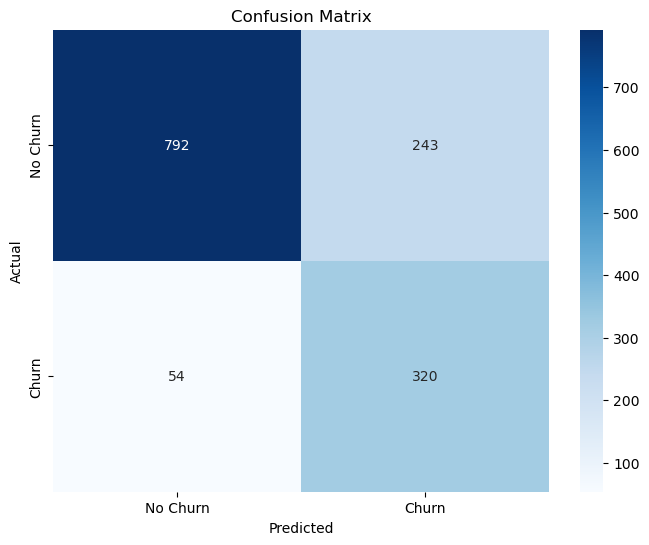

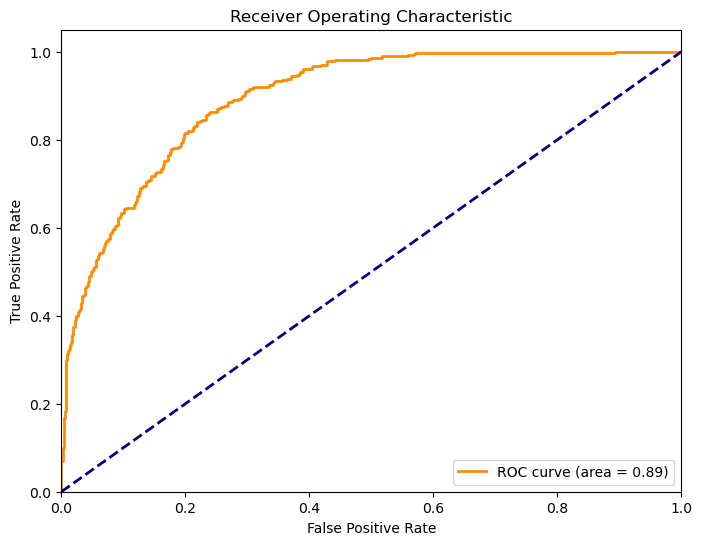

In [18]:
# Evaluate on test set
evaluate_model(lr_grid_search.best_estimator_, score=f1_score)

## 5.2 Gradient boosting

In [19]:
gb_param_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__learning_rate": [0.001, 0.01, 0.1, 0.2],
    "model__max_depth": [3, 5, 7],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 3, 5],
    "model__subsample": [0.7, 0.8, 1.0]
}

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(random_state=42))
])

gb_grid_search = RandomizedSearchCV(
    gb_pipeline,
    param_distributions=gb_param_grid,
    n_iter=15,
    scoring=precision_scorer,
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

gb_grid_search.fit(X_train, y_train)

# Get best parameters and score
print(f"Best parameters: {gb_grid_search.best_params_}")
print(f"Best precision: {gb_grid_search.best_score_:.4f}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'model__subsample': 0.8, 'model__n_estimators': 50, 'model__min_samples_split': 10, 'model__min_samples_leaf': 5, 'model__max_depth': 7, 'model__learning_rate': 0.01}
Best precision: 0.9136


precision_score on test set: 0.8676470588235294

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.99      0.86      1035
           1       0.87      0.16      0.27       374

    accuracy                           0.77      1409
   macro avg       0.82      0.57      0.57      1409
weighted avg       0.79      0.77      0.71      1409



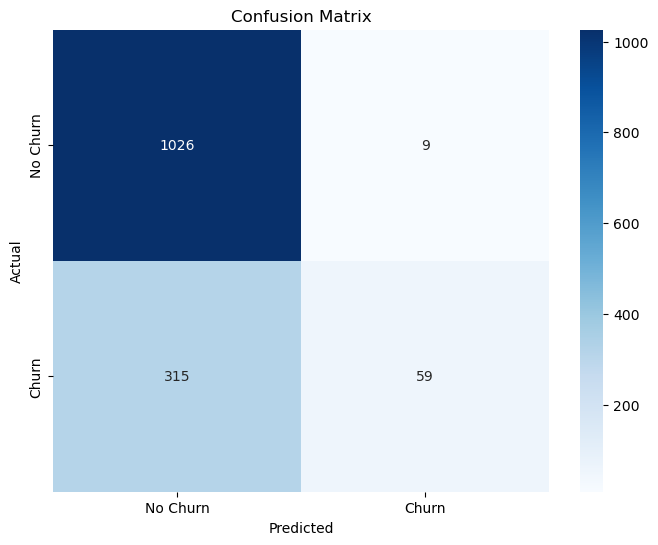

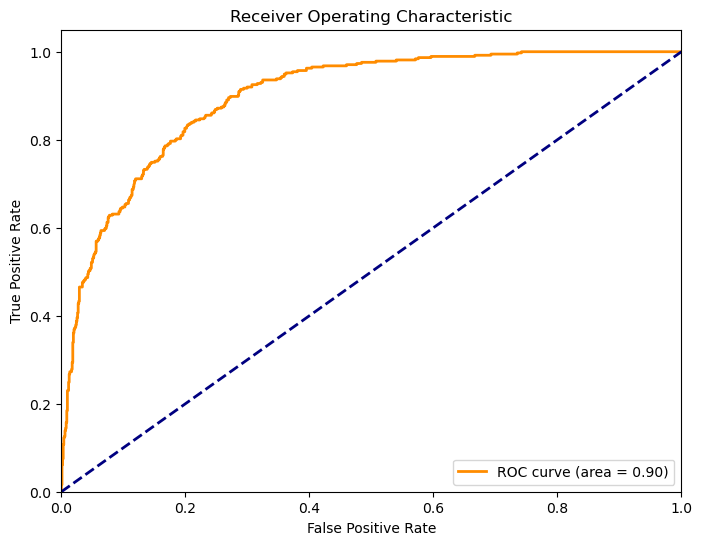

In [20]:
# Evaluate on test set
evaluate_model(gb_grid_search.best_estimator_, score=precision_score)

## 5.3 Linear SVC

In [21]:
svc_param_grid = {
    'model__C': [0.1, 1, 10, 100],
    'model__dual': [True, False],
    'model__tol': [1e-4, 1e-5]
}

svc_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearSVC(
        random_state=42,
        max_iter=50000,
        class_weight='balanced'
    ))
])

svc_grid_search = RandomizedSearchCV(
    svc_pipeline,
    param_distributions=svc_param_grid,
    n_iter=15,
    scoring=recall_scorer,
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

svc_grid_search.fit(X_train, y_train)

# Get best parameters and score
print(f"Best parameters: {svc_grid_search.best_params_}")
print(f"Best recall: {svc_grid_search.best_score_:.4f}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number 

Best parameters: {'model__tol': 1e-05, 'model__dual': True, 'model__C': 100}
Best recall: 0.8615


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


recall_score on test set: 0.8636363636363636

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.75      0.83      1035
           1       0.55      0.86      0.67       374

    accuracy                           0.78      1409
   macro avg       0.75      0.81      0.75      1409
weighted avg       0.84      0.78      0.79      1409



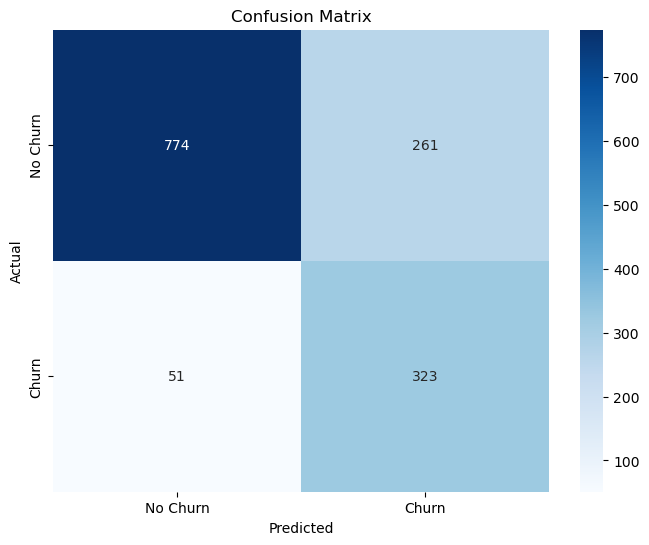

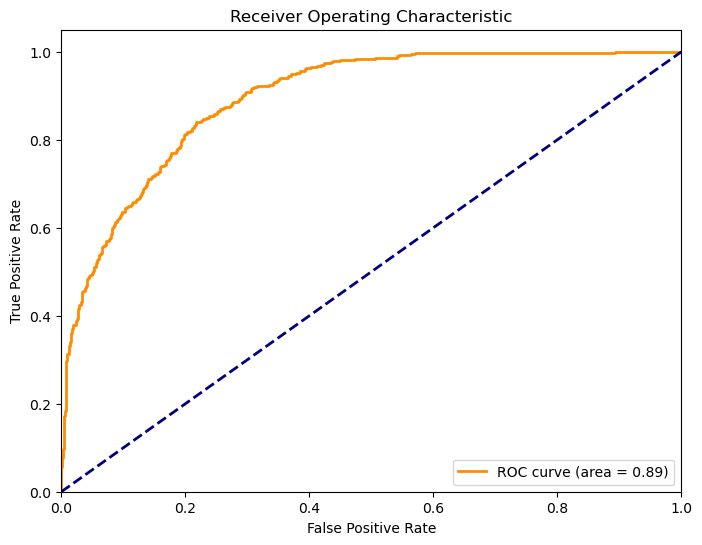

In [22]:
# Evaluate on test set
evaluate_model(svc_grid_search.best_estimator_, score=recall_score)

## 6. Feature importance

## 6.1 Logistic regression feature importance

In [ ]:
# Helper function for getting feature names from a grid search
def get_feature_names(grid_search):
    num_feature_names = grid_search.best_estimator_.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
    cat_feature_names = grid_search.best_estimator_.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()

    return np.concatenate([num_feature_names, cat_feature_names])

In [24]:
# Sanity check on feature names
get_feature_names(lr_grid_search)

array(['age', 'married', 'number_of_dependents', 'number_of_referrals',
       'tenure_in_months', 'phone_service',
       'avg_monthly_long_distance_charges', 'multiple_lines',
       'avg_monthly_gb_download', 'online_security', 'online_backup',
       'device_protection_plan', 'premium_tech_support', 'streaming_tv',
       'unlimited_data', 'paperless_billing', 'monthly_charge',
       'total_refunds', 'total_extra_data_charges', 'cltv', 'streaming',
       'log_total_long_distance_charges', 'log_total_revenue',
       'gender_Female', 'gender_Male', 'offer_Offer A', 'offer_Offer B',
       'offer_Offer C', 'offer_Offer D', 'offer_Offer E',
       'offer_no_offer', 'internet_type_Cable', 'internet_type_DSL',
       'internet_type_Fiber Optic', 'internet_type_no_internet',
       'contract_Month-to-Month', 'contract_One Year',
       'contract_Two Year', 'payment_method_Bank Withdrawal',
       'payment_method_Credit Card', 'payment_method_Mailed Check'],
      dtype=object)

In [25]:
lr_grid_search.best_estimator_.named_steps['model']

LogisticRegression(C=1, class_weight='balanced', l1_ratio=0.9, max_iter=2000,
                   penalty='elasticnet', random_state=42, solver='saga')

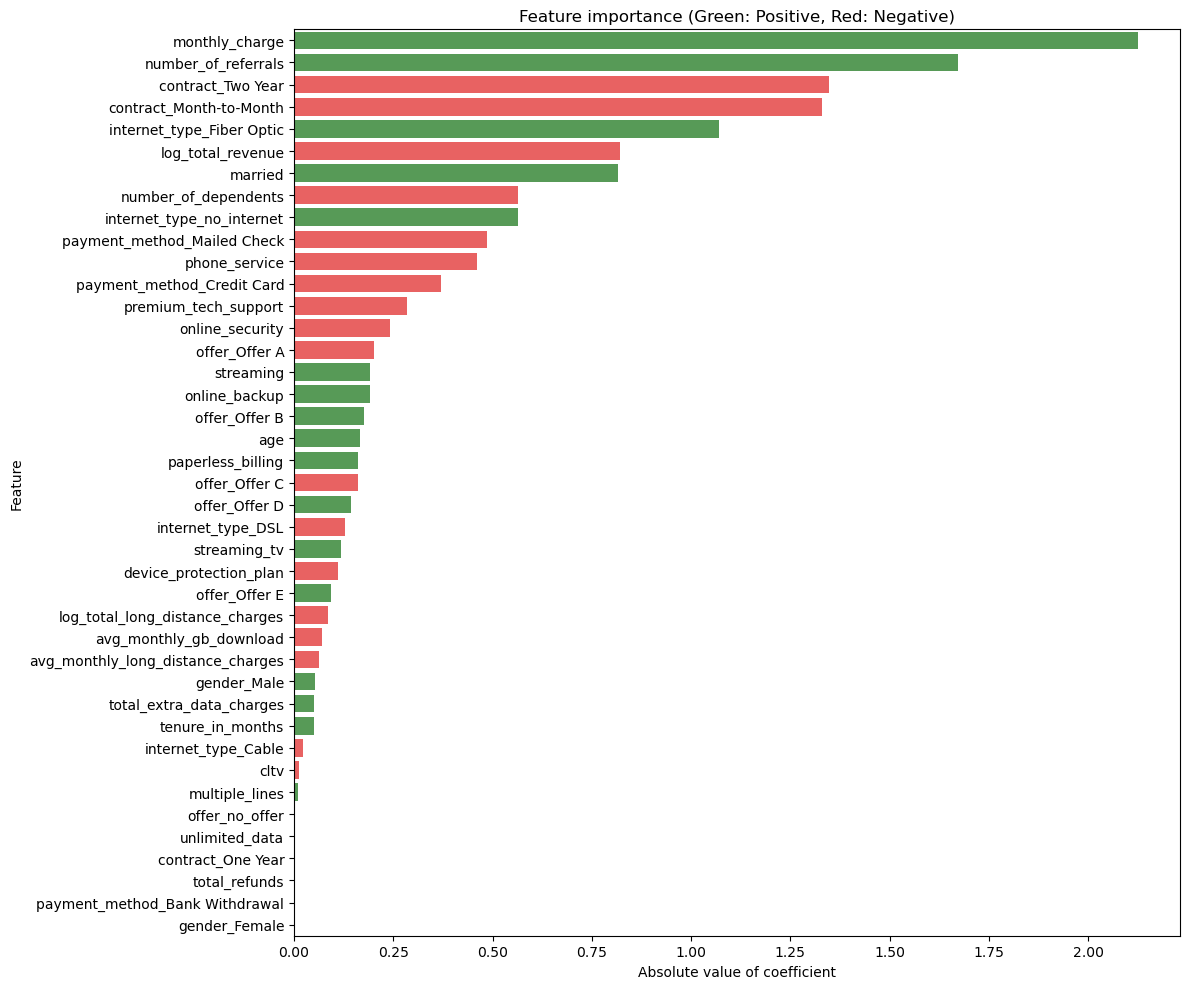

In [26]:
coefficients = lr_grid_search.best_estimator_.named_steps['model'].coef_[0]

feature_importance = pd.DataFrame({
    'feature': get_feature_names(lr_grid_search),
    'importance': np.abs(coefficients)
})

feature_importance.sort_values('importance', ascending=False, inplace=True)

colors = ['red' if c < 0 else 'green' for c in coefficients]

plt.figure(figsize=(12, 10))
sns.barplot(data=feature_importance, x='importance', y='feature',
            palette=colors, alpha=0.7)
plt.title("Feature importance (Green: Positive, Red: Negative)")
plt.xlabel("Absolute value of coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Here, the coefficients reflect how each feature impacts the log-odds of the outcome.

- Magnitude (`abs(coefficients)`) indicates how strongly the feature influences the prediction of the model.

- Sign (positive or negative) indicates the direction of the relationship; whether the likelihood of churn (positive outcome of the target) increases as the feature increases.

---

This notebook is still in progress. In the next steps, I'll focus on the following:

- feature importance

- summary of model performances

- key drivers of churn

Corrections, comments, or suggestions are welcome!